In [61]:
import time

import orbax.checkpoint as ocp
from ml_collections import ConfigDict
from pathlib import Path
from utils import prepare_test_dataset
from dataset_utils import get_dataset
from jax import random
from models.utils import sample_gaussian

from flax import linen as nn
import jax
from jax import jacrev
from functools import partial
from jax.scipy.special import logsumexp
import jax.numpy as jnp
import matplotlib.pyplot as plt
from tqdm import tqdm

import models.ClassifierGFZ as ClassifierGFZ
import models.ClassifierDFZ as ClassifierDFZ

checkpoint_path = "dfz-2-epochs-first-try-1"
path = Path.cwd() / Path(f"checkpoints") / Path(checkpoint_path)
checkpoint = ocp.PyTreeCheckpointer().restore(path, item=None)

config = ConfigDict(checkpoint["config"])
dataset_config = ConfigDict(checkpoint["dataset_config"])

if config.model_name == "GFZ":
    classifier = ClassifierGFZ
elif config.model_name == "DFZ":
    classifier = ClassifierDFZ
else:
    raise NotImplementedError(config.model_name)

_, test_ds = get_dataset(config.dataset)
test_images, test_labels = prepare_test_dataset(
    test_ds, dataset_config
    )

trained_params = checkpoint["params"]

log_likelyhood_fn = classifier.log_likelyhood_A

test_key = random.PRNGKey(1111)

test_key, model, _ = classifier.create_and_init(
    test_key, config, dataset_config
)

/opt/homebrew/Caskroom/miniforge/base/envs/pgm/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1346: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs.
  warnings.warn(


In [63]:
def init_data(test_key, n_samples=10):
    test_key, choice_key = random.split(test_key)
    idx = random.choice(choice_key, jnp.arange(len(test_images)), (n_samples,), replace=False)

    all_xs = test_images[idx]
    true_ys = test_labels[idx]
    true_labels = jnp.argmax(true_ys, axis=1)

    K = model.K
    batch_size = n_samples
    test_key, epsilons = sample_gaussian(test_key, (batch_size, model.n_classes * K, model.d_latent))
    epsilons = epsilons[:n_samples*model.n_classes]
    all_ys = nn.one_hot(jnp.repeat(jnp.arange(model.n_classes), K), model.n_classes, dtype=jnp.float32)
    
    return test_key, all_xs, true_labels, epsilons, all_ys, K

def get_model_output(x, epsilon, y, K):
    z, logit_q_z_xy, logit_p_x_z, logit_p_y_xz = jax.vmap(
            partial(model.apply, {'params': trained_params}, train=False),
            in_axes=(None, 0, 0)
        )(x, y, epsilon)

    ll = log_likelyhood_fn(
            z, logit_q_z_xy, logit_p_x_z, logit_p_y_xz
        ).reshape(model.n_classes, K)
    ll = logsumexp(ll, axis=1) - jnp.log(K)
    return ll

def get_model_jacobian(x, epsilon, y, K):
    return jacrev(get_model_output, argnums=0)(x, epsilon, y, K)

def map_label_to_name(y):
    labels = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
              "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
    return labels[y]

In [70]:
class DeepFool():
    def __init__(self, model, max_iter=100, learning_rate=1):
        self.model = model
        self.n_classes = model.n_classes
        self.max_iter = max_iter
        self.learning_rate = learning_rate

    def get_label(self, x, epsilon):
        val = get_model_output(x, epsilon, self.y, self.K)
        return jnp.argmax(val)

    def get_likelihoods_and_gradients(self, x, epsilon):
        
        ## ToDo: check why this becomes very slow after a few iterations
        J = get_model_jacobian(x, epsilon, self.y, self.K)
        val = get_model_output(x, epsilon, self.y, self.K)
        return val, J

    def get_perturbation(self, x, epsilon, all_ys, K):
        corrupted_x = x.copy()
        self.y = all_ys
        self.K = K
        new_label = self.get_label(corrupted_x, epsilon)
        k = self.get_label(x, epsilon)

        @jax.jit
        def pertubate(x):
            likelihoods, gradients = self.get_likelihoods_and_gradients(x, epsilon)
            w = gradients - gradients[None,k,...]
            f = likelihoods - likelihoods[None,k]
            perturbation = jnp.abs(f) / jnp.linalg.norm(w.squeeze(), axis=(1, 2))
            perturbation = perturbation.at[k].set(jnp.inf)
            idx = jnp.argmin(perturbation)
            r_i = perturbation[idx] * w[idx] / jnp.linalg.norm(w[idx])
            x += self.learning_rate * r_i
            return x
        
        for iter in range(self.max_iter):
            corrupted_x = pertubate(corrupted_x)
            new_label = self.get_label(corrupted_x, epsilon)
            if new_label != k:
                break
        perturbation_norm = jnp.linalg.norm(corrupted_x - x) / jnp.linalg.norm(x)
        return corrupted_x, new_label, perturbation_norm

In [77]:
def get_average_performance(corruption_model, all_xs, epsilons, all_ys, K):
    perturbation_norms = []
    n_samples = len(all_xs)
    for i in tqdm(range(n_samples)):
        x = all_xs[i]
        epsilon = epsilons[i]
        _, _, perturbation_norm = corruption_model.get_perturbation(x, epsilon, all_ys, K)
        perturbation_norms.append(perturbation_norm)
    return perturbation_norms

In [78]:
def get_average_performance_jax(corruption_model, all_xs, epsilons, all_ys, K):
    perturbation_norms = jax.vmap(
        partial(corruption_model.get_perturbation, all_ys=all_ys, K=K),
        in_axes=(0, 0),
        out_axes=(None, None, 0)
    )(all_xs, epsilons)
    return perturbation_norms

In [79]:
n_samples = 100
test_key, all_xs, true_labels, epsilons, all_ys, K = init_data(test_key, n_samples=n_samples)

corruption_model = DeepFool(model)

#perturbation_norms = get_average_performance(corruption_model, all_xs, epsilons, all_ys, K)
perturbation_norms = get_average_performance_jax(corruption_model, all_xs, epsilons, all_ys, K)

print(f'Average perturbation norm: {jnp.mean(perturbation_norms):>.4f}')

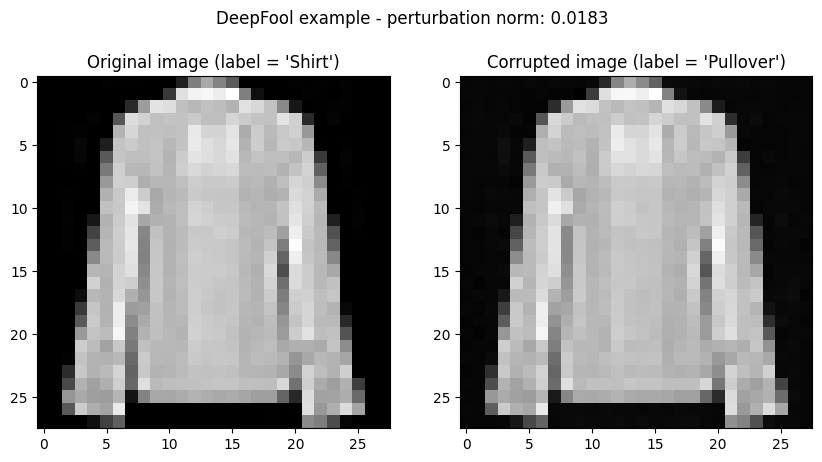

In [58]:
i = np.random.randint(n_samples)

x = all_xs[i]
epsilon = epsilons[i]
true_label = true_labels[i]

corruption_model = DeepFool(model, learning_rate=0.2)
corrupted_x, new_label, perturbation_norm = corruption_model.get_perturbation(x, epsilon, all_ys, K)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(x.reshape(28, 28), cmap="gray")
axs[0].set_title(f"Original image (label = '{map_label_to_name(true_label)}')")
axs[1].imshow(corrupted_x.reshape(28, 28), cmap="gray")
axs[1].set_title(f"Corrupted image (label = '{map_label_to_name(new_label)}')")
fig.suptitle(f"DeepFool example - perturbation norm: {perturbation_norm:.4f}")
plt.show()